## 分类问题的评估方法

In [112]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 1 数据集读取
- 我们直接使用sklearn提供数据集
- Mnist是手写字体数据集
- Mnist数据是图像数据：(28,28,1)的灰度图 1是颜色通道的值

In [113]:
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784")
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [114]:
X, y = mnist["data"], mnist["target"]
# y = y.astype(np.uint8)
X.shape
# 数据大小 784 是灰度图像素数量 即784维特征值

(70000, 784)

In [115]:
y.shape

(70000,)

![title](./img/9.png)

In [116]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# 训练集6w 测试集1w

In [117]:
import numpy as np
# 洗牌操作 打乱顺序
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

In [118]:
# 展示打乱后的序号
shuffle_index

array([12628, 37730, 39991, ...,   860, 15795, 56422])

### 2 交叉验证(Cross Calidation)

![title](./img/5.png)

In [119]:
# 值为0-9的字符串
y_train

12628    7
37730    3
39991    8
8525     9
8279     3
        ..
54343    3
38158    8
860      0
15795    0
56422    4
Name: class, Length: 60000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

![title](./img/7.png)

In [120]:
# 将训练集每次拿出一份作为验证集 每次交叉验证切分不同份 以保证交叉
# 建立二分类任务 图像的值是否为5
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [121]:
y_train_5[:10]

12628    False
37730    False
39991    False
8525     False
8279     False
51012    False
14871    False
15127    False
9366      True
33322    False
Name: class, dtype: bool

In [122]:
# 在sklearn提供的算法模型中 选择线性分类器 梯度下降
from sklearn.linear_model import SGDClassifier
# 实例化分类器 指定参数
sgd_clf = SGDClassifier(max_iter=5,random_state=42)
# 训练
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [123]:
# 预测
(predict_tag,tag)=sgd_clf.predict([X.iloc[11011]]),y[11011]
predict_tag,tag

(array([False]), '3')

In [124]:
(p,t)=sgd_clf.predict([X.iloc[35000]]),y[35000]
p,t

(array([False]), '1')

In [125]:
# 选择sklearn提供的交叉验证函数
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score
cross_val_score(
sgd_clf,
X_train,y_train_5,
cv=3,#splitting strategy
scoring='accuracy'
)

array([0.964 , 0.9579, 0.9571])

In [126]:
X_train.shape

(60000, 784)

In [127]:
y_train_5.shape

(60000,)

In [128]:
# 自定义交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skflods = StratifiedKFold(n_splits=3)
i=0;
for train_index,test_index in skflods.split(X_train,y_train_5):
    # 每一份都使用clone的分类器 使参数相同 以保证公平
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5[test_index]
    # 训练
    clone_clf.fit(X_train_folds,y_train_folds)
    # 预测
    y_pred = clone_clf.predict(X_test_folds)
    # 一共作对多少个
    n_correct = sum(y_pred == y_test_folds)
    i=i+1
    print(i,n_correct/len(y_pred))

1 0.9
2 0.2478
3 0.44615


### 3 混淆矩阵(Confusion Matrix)

![title](./img/8.png)

- TN:正确地当成负例找出 把男生当成男生找出 50 | FP:错误地当成正例找出 把男生当成女生找出 30
- FN:错误地当成负例找出 把女生当成男生找出 0  | TP:正确地当成正例找出 把女生当成女生找出 20

In [129]:
from sklearn.model_selection import cross_val_predict
# 交叉验证 不返回结果分值 而是每个样本预测的结果
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [130]:
y_train_pred.shape

(60000,)

In [131]:
X_train.shape

(60000, 784)

In [132]:
from sklearn.metrics import confusion_matrix
# 混淆矩阵
confusion_matrix(
y_train_5, # 标签值
y_train_pred # 预测值
)

array([[54058,   521],
       [ 1899,  3522]])

```python
array([[53272,  1307],
       [ 1077,   4344]])
```
negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

二分类
- TN(true negatives):被正确的分为**非5类别** 53272  | FP(false positives):被错误的分为**5类别** 1307
- FN(false negatives):错误的分为**非5类别** 1077    | TP(true positives):被正确的分为**5类别** 4344
 
一个完美的分类器应该只有**true positives** 和 **true negatives**, 即主对角线元素不为0，其余元素为0

### 4 Precision and Recall
精度 **$ precision = \frac {TP} {TP + FP} $**

召回率 **$ recall = \frac {TP} {TP + FN} $**

![title](./img/1.png)

In [133]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8711352955725946

In [134]:
recall_score(y_train_5,y_train_pred)

0.6496956281128943

将**Precision** 和 **Recall**结合到一个称为**F1 score** 的指标,调和平均值给予低值更多权重。 因此，如果召回和精确度都很高，分类器将获得高F 1分数。

### $ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$

In [135]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7442941673710904

### 5 阈值对结果的影响

![title](./img/2.png)

In [136]:
# 样本预测的得分
y_scores = sgd_clf.decision_function([X.iloc[35000]])
y_scores

array([-232764.96231592])

In [137]:
# 损毁值
t = 50000
# 可接受的阈值
y_pred = (y_scores > t)
y_pred

array([False])

Scikit-Learn不允许直接设置阈值，但它可以得到决策分数，

调用其**decision_function（）**方法，而不是调用分类器的**predict（）**方法，该方法返回每个实例的分数，

然后使用想要的**阈值**根据这些分数进行预测：

In [138]:
y_scores = cross_val_predict(
sgd_clf, 
X_train, y_train_5, cv=3,
method="decision_function"
)

In [139]:
y_scores[:10]

array([ -545086.1906455 ,  -200238.20632717,  -366873.76172794,
        -648828.94558457,  -572767.52239341, -1016184.25580999,
        -419438.40135301,  -171080.39957192,   237230.03978349,
        -793932.50331372])

In [140]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [141]:
y_train_5.shape

(60000,)

In [142]:
# 阈值
thresholds.shape

(59781,)

In [143]:
precisions[:10]

array([0.09068099, 0.09066577, 0.09066729, 0.09066881, 0.09067032,
       0.09067184, 0.09067336, 0.09067488, 0.09067639, 0.09067791])

In [144]:
precisions.shape

(59782,)

In [145]:
recalls.shape

(59782,)

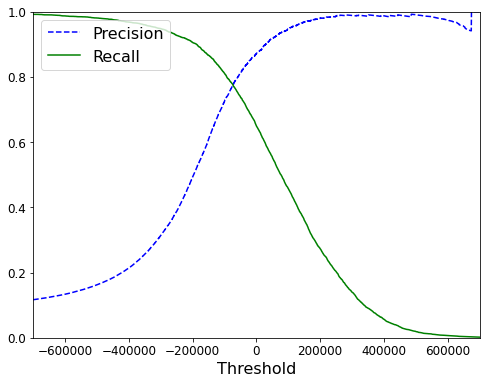

In [146]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,
             precisions[:-1],
            "b--",
            label="Precision")
    
    plt.plot(thresholds,
             recalls[:-1],
            "g-",
            label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="upper left",fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

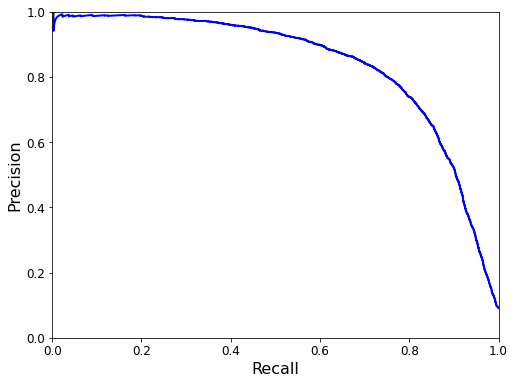

In [147]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, 
             precisions, 
             "b-", 
             linewidth=2)
    
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC curves
**receiver operating characteristic (ROC)** 曲线是二元分类中的常用评估方法
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** 与**false positive rate(FPR)** 

* 要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

TPR = TP / (TP + FN) (Recall)

FPR = FP / (FP + TN)

In [148]:
from sklearn.metrics import roc_curve
# ROC计算
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

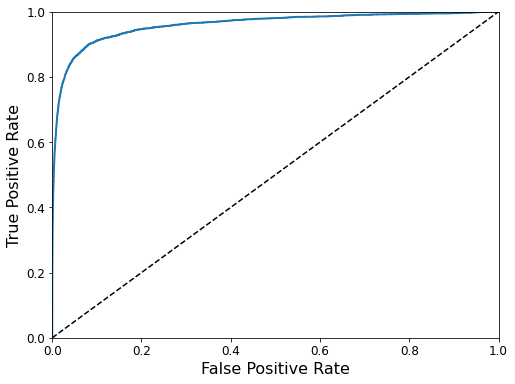

In [149]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

**虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量**曲线下面积**（AUC）。

完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [150]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9598058535696421